In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Import training data
train_df = pd.read_csv("C:/Users/peiha/Desktop/2022_Spring_ApplyAI/Project/Dataset/train.csv")
train_df.head(2)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1


In [3]:
print("Number of rows in training dataset:", len(train_df))

Number of rows in training dataset: 75757


In [4]:
# Import test data
test_df = pd.read_csv("C:/Users/peiha/Desktop/2022_Spring_ApplyAI/Project/Dataset/test.csv")
test_df.head(2)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758


In [5]:
print("Number of rows in test dataset:", len(test_df))

Number of rows in test dataset: 9705


In [6]:
# Briefly explore the training data
#train_df.info()

In [7]:
# Get NaN values on each column
train_df.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

In [8]:
#pull numeric features
df_with_numeric_features = train_df.select_dtypes(exclude=['object'])
#print("Numeric features:")
#for col in df_with_numeric_features:
#    print(f"{col}")

In [9]:
# Pull non-numeric features
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [10]:
# Remove duplicates
column_names = train_df.columns.tolist()
#column_names

In [11]:
column_names.remove('id')

train_df.drop_duplicates(subset=column_names, keep='last', inplace=True)
print("Number of rows after removing duplicates", len(train_df))

Number of rows after removing duplicates 75718


In [12]:
# Fix structural errors
df_with_non_numeric_features.columns

Index(['State_Factor', 'building_class', 'facility_type'], dtype='object')

In [13]:
#train_df['facility_type'].value_counts()

In [14]:
# Convert to lower case
# train_df['facility_type'] = train_df['facility_type'].str.lower()
# train_df['facility_type'].value_counts()

In [15]:
# Check the range of values
#print("Numeric features:")
#for col in df_with_numeric_features:
#    print(f"{col}")

In [16]:
# Filter outliers

features_considered = ['Year_Factor', 'floor_area','year_built', 'energy_star_rating', 'ELEVATION','cooling_degree_days',\
                       'heating_degree_days','avg_temp','site_eui']
# calculate z-scores for numeric features
z_scores = zscore(train_df[features_considered], nan_policy='omit')
#z_scores

In [17]:
# convert to absolute values
abs_z_scores = np.abs(z_scores)
# filter based on |z-score| less than 3
filtered_entries = (abs_z_scores < 3).all(axis=1)
filtered_entries

array([ True,  True,  True, ..., False, False, False])

In [18]:
print("Outliers present in the dataset")
train_df.loc[filtered_entries == False]

Outliers present in the dataset


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
13,1,State_1,Commercial,Data_Center,616793.0,1955.0,13.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,608.839519,13
14,1,State_1,Commercial,Commercial_Other,53000.0,1924.0,NaN,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,2.699413,14
15,1,State_1,Commercial,Office_Uncategorized,90045.0,NaN,NaN,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,24.600000,15
17,1,State_1,Commercial,Office_Uncategorized,128800.0,1926.0,NaN,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,33.580371,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75749,6,State_11,Commercial,Commercial_Other,47237.0,1948.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,126.285151,75749
75750,6,State_11,Commercial,Commercial_Other,72000.0,2013.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,40.525884,75750
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755


In [19]:
df_without_outliers = train_df[filtered_entries]
print('Number of rows after filtering outliers:', len(df_without_outliers))
train_df = df_without_outliers;
df_without_outliers.head()

Number of rows after filtering outliers: 44589


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [20]:
# Handle missing values

#Find columns which have missing values
train_df.isna().sum()[train_df.isna().sum()>0]
#pd.set_option('display.max_rows', None)
#train_df.isna().sum()

direction_max_wind_speed     23955
direction_peak_wind_speed    24512
max_wind_speed               23955
days_with_fog                27915
dtype: int64

In [21]:
#Delete columns that have missing values
train_df = train_df.drop(columns=['id','direction_max_wind_speed','direction_peak_wind_speed',\
                                  'max_wind_speed','days_with_fog'])

In [22]:
#Delete rows that have missing values
#train_df = train_df.dropna(subset = ['id','direction_max_wind_speed','direction_peak_wind_speed',\
#                                     'max_wind_speed','days_with_fog']).reset_index(drop = True)

In [23]:
# get count of missing value in train_df
train_df.columns[train_df.isna().any()].tolist()

[]

In [24]:
print("Number of rows in training data after filtering missing values:", len(train_df))
train_df.head()

Number of rows in training data after filtering missing values: 44589


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [25]:
# Do the same for the test data
test_df.isna().sum()[test_df.isna().sum()>0]

year_built                     92
energy_star_rating           2254
direction_max_wind_speed     8575
direction_peak_wind_speed    8575
max_wind_speed               8575
days_with_fog                9117
dtype: int64

In [26]:
#Delete columns that have missing values
test_df = test_df.drop(columns=['id','direction_max_wind_speed','direction_peak_wind_speed',\
                                  'max_wind_speed','days_with_fog'])
#Delete rows that have missing values
test_df = test_df.dropna(subset = ['year_built','energy_star_rating']).reset_index(drop = True)

In [27]:
print("Number of rows in testing data after filtering missing values:", len(test_df))
test_df.head()

Number of rows in testing data after filtering missing values: 7401


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,59.894521,0,0,0,0,29,5,2,0
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,59.894521,0,0,0,0,29,5,2,0
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,59.894521,0,0,0,0,29,5,2,0
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,59.894521,0,0,0,0,29,5,2,0
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,59.894521,0,0,0,0,29,5,2,0


In [28]:
# Fill in values with a specific values (imputation)
#train_df.year_built.plot()

In [29]:
numeric_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('site_eui')
cor_matrix = train_df[numeric_features + ['site_eui']].corr()
#cor_matrix

In [30]:
#plt.figure(figsize = (20,20))
#sns.heatmap(cor_matrix, annot = True)

In [31]:
#cor_matrix['site_eui'].abs() > 0.2

In [32]:
features_with_higher_cor_to_target = cor_matrix['site_eui'][cor_matrix['site_eui'].abs() > 0.2].index.tolist()
features_with_higher_cor_to_target.remove('site_eui')
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'march_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_above_80F']


In [33]:
# Mutual Info Regression
#numeric_features = np.array(numeric_features)
#m_info = mutual_info_regression(train_df[numeric_features], train_df['site_eui'], \
#                                discrete_features=[0, 3, 4, 6], n_neighbors=5)
#features_with_higher_mutual_info = numeric_features[m_info>0.2]
#print("Features selected ", features_with_higher_mutual_info)

In [34]:
# Convert categorical variables to numerical

# grab non-numeric features
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [35]:
train_df['State_Factor'].value_counts()

State_6     29231
State_11     4678
State_2      3749
State_4      2912
State_8      2096
State_1      1914
State_10        9
Name: State_Factor, dtype: int64

In [36]:
train_df['building_class'].value_counts()

Residential    25392
Commercial     19197
Name: building_class, dtype: int64

In [37]:
#train_df['facility_type'].value_counts()

In [38]:
# OneHotEncoding 'State_Factor'
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [39]:
# Create a Pandas DataFrame of the hot encoded column
transformed = encoder.transform(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_train = pd.DataFrame(transformed, columns=encoder.get_feature_names())

In [40]:
# Concat with original data
train_df.reset_index(drop=True, inplace=True)
ohe_df_train.reset_index(drop=True, inplace=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
train_df = train_df.drop(['State_Factor'], axis=1)
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,...,0,0,248.682615,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,...,0,0,26.500150,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,...,0,0,24.693619,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,...,0,0,48.406926,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,...,0,0,3.899395,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Perform the same on test data
transformed = encoder.transform(np.array(test_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_test = pd.DataFrame(transformed, columns=encoder.get_feature_names())

test_df = pd.concat([test_df, ohe_df_test], axis=1)
test_df = test_df.drop(['State_Factor'], axis=1)
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_90F,days_above_100F,days_above_110F,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,7,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Encode ordinal values

encode_categorical_values = {"Residential":0, "Commercial":1}
train_df['building_class'] = train_df['building_class'].replace(encode_categorical_values) 
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,1,1,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,...,0,0,248.682615,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,...,0,0,26.500150,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,...,0,0,24.693619,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,...,0,0,48.406926,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,...,0,0,3.899395,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Perform the same on test data
encode_categorical_values = {"Residential":0, "Commercial":1}
test_df['building_class'] = test_df['building_class'].replace(encode_categorical_values) 
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_90F,days_above_100F,days_above_110F,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,7,1,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,1,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,...,5,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Log Transformation
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'march_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_above_80F']


In [45]:
#ax = sns.displot(train_df['site_eui'])

In [46]:
#sns.displot(np.log(train_df.loc[train_df['site_eui']!=0, 'site_eui']))

In [47]:
# Scaling and Normalization

#Standardization (transform to mean=0, sd=1)
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,-3.050279,-0.595290,-0.354799,-1.752607,-0.719772,2.917979,2.782527,2.403581,2.194765,1.944097,...,-1.118633,0.591525,-2.030605,-1.453784,-0.907547,-0.345315,-2.864922,-1.433966,-0.145984,0.0
1,-3.050279,0.896370,0.045534,-0.560797,-0.731960,2.917979,2.782527,2.403581,2.194765,1.944097,...,-1.118633,0.591525,-2.030605,-1.453784,-0.907547,-0.345315,-2.864922,-1.433966,-0.145984,0.0
2,-3.050279,0.938612,-0.077645,1.261970,-0.731960,2.917979,2.782527,2.403581,2.194765,1.944097,...,-1.118633,0.591525,-2.030605,-1.453784,-0.907547,-0.345315,-2.864922,-1.433966,-0.145984,0.0
3,-3.050279,-0.636775,0.815407,-0.525744,-0.731960,2.917979,2.782527,2.403581,2.194765,1.944097,...,-1.118633,0.591525,-2.030605,-1.453784,-0.907547,-0.345315,-2.864922,-1.433966,-0.145984,0.0
4,-3.050279,-0.561932,0.969381,1.367130,-0.719772,2.917979,2.782527,2.403581,2.194765,1.944097,...,-1.118633,0.591525,-2.030605,-1.453784,-0.907547,-0.345315,-2.864922,-1.433966,-0.145984,0.0


In [48]:
#Perform the same on the test data (HINT: don't refit the transform)
scaler = StandardScaler()
test_df[numeric_features] = scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,0.0,-0.578542,0.708966,-0.989860,-0.788525,2.05795,2.067658,0.673043,1.95364,2.432407,...,-0.675606,1.683174,-1.349314,-0.937766,-0.856542,-0.65438,-1.294259,-0.562407,3.126168,0.0
1,0.0,-0.604894,-0.082185,-0.345600,-0.620821,2.05795,2.067658,0.673043,1.95364,2.432407,...,-0.675606,1.683174,-1.349314,-0.937766,-0.856542,-0.65438,-1.294259,-0.562407,3.126168,0.0
2,0.0,-0.628001,-0.345902,-2.278381,-0.568921,2.05795,2.067658,0.673043,1.95364,2.432407,...,-0.675606,1.683174,-1.349314,-0.937766,-0.856542,-0.65438,-1.294259,-0.562407,3.126168,0.0
3,0.0,-0.302369,0.157558,-1.097237,-0.660713,2.05795,2.067658,0.673043,1.95364,2.432407,...,-0.675606,1.683174,-1.349314,-0.937766,-0.856542,-0.65438,-1.294259,-0.562407,3.126168,0.0
4,0.0,-0.447310,-0.537696,-1.061445,-0.790849,2.05795,2.067658,0.673043,1.95364,2.432407,...,-0.675606,1.683174,-1.349314,-0.937766,-0.856542,-0.65438,-1.294259,-0.562407,3.126168,0.0


In [49]:
#Normalization through Min/Max scaling
min_max_scaler = MinMaxScaler()
train_df[numeric_features] = min_max_scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,0.0,0.065551,0.570588,0.101010,0.002737,0.978723,0.931209,0.866667,0.872727,0.850947,...,0.0,0.676295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.302547,0.647059,0.444444,0.000000,0.978723,0.931209,0.866667,0.872727,0.850947,...,0.0,0.676295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.309258,0.623529,0.969697,0.000000,0.978723,0.931209,0.866667,0.872727,0.850947,...,0.0,0.676295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.058960,0.794118,0.454545,0.000000,0.978723,0.931209,0.866667,0.872727,0.850947,...,0.0,0.676295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.070851,0.823529,1.000000,0.002737,0.978723,0.931209,0.866667,0.872727,0.850947,...,0.0,0.676295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
#Perform the same on the test data
min_max_scaler = MinMaxScaler()
test_df[numeric_features] = min_max_scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,0.0,0.005026,0.989087,0.363636,0.000741,1.0,1.0,0.758621,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.130841,0.1,1.0,0.0
1,0.0,0.003557,0.972718,0.545455,0.054184,1.0,1.0,0.758621,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.130841,0.1,1.0,0.0
2,0.0,0.002268,0.967262,0.000000,0.070723,1.0,1.0,0.758621,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.130841,0.1,1.0,0.0
3,0.0,0.020423,0.977679,0.333333,0.041471,1.0,1.0,0.758621,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.130841,0.1,1.0,0.0
4,0.0,0.012342,0.963294,0.343434,0.000000,1.0,1.0,0.758621,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.130841,0.1,1.0,0.0


In [51]:
train_df.isna().sum()[train_df.isna().sum()>0]

Series([], dtype: int64)

In [52]:
# Dimensionality Reduction using PCA

# Split the training data and test data from train_df with 8:2 using scikit-learn
training_data, testing_data = train_test_split(train_df, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 35671
No. of testing examples: 8918


In [53]:
y_train = training_data['site_eui']
X_train = training_data.drop(columns = ['site_eui','facility_type'])
# same for test data
y_test = testing_data['site_eui']
X_test = testing_data.drop(columns = ['site_eui','facility_type'])

In [54]:
lr_classifier = LinearRegression()
lr_classifier.fit(X_train, y_train)

LinearRegression()

In [55]:
y_pred = lr_classifier.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred))

MSE 720.1321960339476


In [56]:
performance_across_n_comp = []
for n_components in range(1, len(train_df.columns) - 2):
    pca = PCA(n_components)
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)

    lr_classifier = LinearRegression()
    lr_classifier.fit(X_train_transformed, y_train)
    y_pred_i = lr_classifier.predict(X_test_transformed)
    performance_across_n_comp.append(mean_squared_error(y_test, y_pred_i))

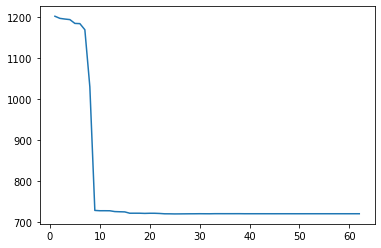

In [57]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)

In [58]:
# compare MSE of full model to PCA regression with 16 components
abs(performance_across_n_comp[15] - mean_squared_error(y_test, y_pred))

1.216651789302091

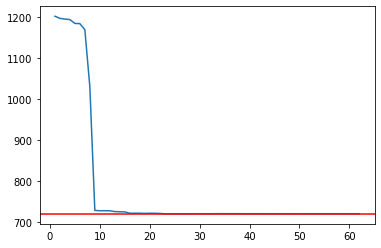

In [59]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)
plt.axhline(y=mean_squared_error(y_test, y_pred), color='r', linestyle='-')